In [1]:
#%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import display
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

verbose=True

def pprint(content,visible=verbose):
    if visible:
        if isinstance(content, str) :
            print(' => '+content+'\n')
        else :
            if 'matplotlib' in str(type(content)):
                plt.figure()
            display(content)

def hist_text(series,left=0,right=1,bins=10):
    return series.groupby(pd.cut(series, [(x/bins)*(right-left)+left for x in range(bins+1)],include_lowest=True)).count()

In [2]:
def load_data(url="https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"):
    '''
    Loads Data (similar to sklearn.datasets.load_boston)

    :param url: space separated file location containing Boston housing data
    :return: Raw pd.df containing Boston housing data
    '''
    ### Harrison (1978)과 평균값, Belsley (1980)와 첫 데이터를 비교하여 이상 없음을 확인했음
    # CRIM - 범죄율 (1인당)
    # ZN - large-lot zone 비율 (25000sqft 이하의 주택이 금지되는 구역)
    # INDUS - 산업지구 비율 (공해도)
    # CHAS - 더미 변수 (찰스강 경계에 위치 = 1, 아니면 = 0)
    # NOX - 일산화질소 농도 (단위 : 10pphm, parts per 10 million)
    # RM - 가구당 방의 개수 (부동산 품질)
    # AGE - 오래된 자가주택 비율 (1940년 기준, 구조물 품질에 관련됨)
    # DIS - 고용센터까지의 거리 (통근거리, 가중평균, 로그)
    # RAD - 고속도로 접근성 (공해도, 통근거리, 로그)
    # TAX - 재산세율
    # PTRATIO - 학생-교사 비율
    # B - 흑인 비율 (1000(Bk - 0.63)^2)
    # LSTAT - 하위계층 %비율
    # MEDV - 자가주택 가격 중앙값 (단위 $1000)
    ### 변수 분류
    # 종속변수 : MEDV
    # Structural : RM, AGE
    # Neighborhood : B, LSTAT, CRIM, ZN, INDUS, TAX, PTRATIO, CHAS
    # Accessibility : DIS, RAD
    # Air Pollution : NOX, PART

    names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
    boston_housing_dataframe = pd.read_csv(url, names=names, header=None, delim_whitespace=True)
    return boston_housing_dataframe

df_boston_housing = load_data()
np.random.seed(1); df_boston_housing=df_boston_housing.reindex(np.random.permutation(df_boston_housing.index))
pprint(df_boston_housing.describe())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [3]:
pprint(df_boston_housing)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
307,0.04932,33.0,2.18,0,0.472,6.849,70.3,3.1827,7,222.0,18.4,396.90,7.53,28.2
343,0.02543,55.0,3.78,0,0.484,6.696,56.4,5.7321,5,370.0,17.6,396.90,7.18,23.9
47,0.22927,0.0,6.91,0,0.448,6.030,85.5,5.6894,3,233.0,17.9,392.74,18.80,16.6
67,0.05789,12.5,6.07,0,0.409,5.878,21.4,6.4980,4,345.0,18.9,396.21,8.10,22.0
362,3.67822,0.0,18.10,0,0.770,5.362,96.2,2.1036,24,666.0,20.2,380.79,10.19,20.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.03548,80.0,3.64,0,0.392,5.876,19.1,9.2203,1,315.0,16.4,395.18,9.25,20.9
72,0.09164,0.0,10.81,0,0.413,6.065,7.8,5.2873,4,305.0,19.2,390.91,5.52,22.8
396,5.87205,0.0,18.10,0,0.693,6.405,96.0,1.6768,24,666.0,20.2,396.90,19.37,12.5
235,0.33045,0.0,6.20,0,0.507,6.086,61.5,3.6519,8,307.0,17.4,376.75,10.88,24.0


In [4]:
def cut_data(df, ratio_list):
    '''
    Cuts df into smaller rows
    
    :return: [df1, df2, df3, ...] with size=len(ratio_list)+1
    '''
    if not np.sum(ratio_list)<1 :
        raise Error('invalid ratio_list')
    
    offset = (np.array(ratio_list).cumsum()*df.shape[0]).astype(int).tolist()
    offset = zip([0]+offset,offset+[df.shape[0]])
    return [df.iloc()[x[0]:x[1]] for x in offset]

df_feature = df_boston_housing.copy()
df_targets = pd.DataFrame(df_feature.pop('MEDV'))

df_feature_train, df_feature_test, df_feature_validate = cut_data(df_feature,[0.5,0.2])
df_targets_train, df_targets_test, df_targets_validate = cut_data(df_targets,[0.5,0.2])

<AxesSubplot:>

array([[<AxesSubplot:title={'center':'MEDV'}>,
        <AxesSubplot:title={'center':'CRIM'}>,
        <AxesSubplot:title={'center':'ZN'}>,
        <AxesSubplot:title={'center':'INDUS'}>],
       [<AxesSubplot:title={'center':'CHAS'}>,
        <AxesSubplot:title={'center':'NOX'}>,
        <AxesSubplot:title={'center':'RM'}>,
        <AxesSubplot:title={'center':'AGE'}>],
       [<AxesSubplot:title={'center':'DIS'}>,
        <AxesSubplot:title={'center':'RAD'}>,
        <AxesSubplot:title={'center':'TAX'}>,
        <AxesSubplot:title={'center':'PTRATIO'}>],
       [<AxesSubplot:title={'center':'B'}>,
        <AxesSubplot:title={'center':'LSTAT'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

,AGE,CRIM,INDUS,LSTAT,NOX,PTRATIO,RAD,TAX,B,DIS,ZN,CHAS,RM
AGE,1.00,0.33,0.64,0.57,0.75,0.22,0.44,0.50,-0.26,-0.73,-0.55,0.06,-0.16
CRIM,0.33,1.00,0.39,0.41,0.43,0.27,0.62,0.57,-0.32,-0.37,-0.20,-0.04,-0.12
INDUS,0.64,0.39,1.00,0.60,0.76,0.35,0.56,0.68,-0.34,-0.70,-0.52,0.06,-0.34
LSTAT,0.57,0.41,0.60,1.00,0.60,0.37,0.51,0.56,-0.41,-0.48,-0.42,-0.11,-0.57
NOX,0.75,0.43,0.76,0.60,1.00,0.20,0.63,0.68,-0.38,-0.78,-0.53,0.04,-0.23
PTRATIO,0.22,0.27,0.35,0.37,0.20,1.00,0.44,0.41,-0.18,-0.20,-0.36,-0.16,-0.36
RAD,0.44,0.62,0.56,0.51,0.63,0.44,1.00,0.90,-0.46,-0.48,-0.30,-0.02,-0.19
TAX,0.50,0.57,0.68,0.56,0.68,0.41,0.90,1.00,-0.45,-0.51,-0.32,-0.04,-0.28
B,-0.26,-0.32,-0.34,-0.41,-0.38,-0.18,-0.46,-0.45,1.00,0.28,0.17,0.07,0.11
DIS,-0.73,-0.37,-0.70,-0.48,-0.78,-0.20,-0.48,-0.51,0.28,1.00,0.60,-0.09,0.10


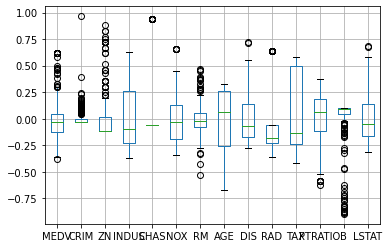

<Figure size 432x288 with 0 Axes>

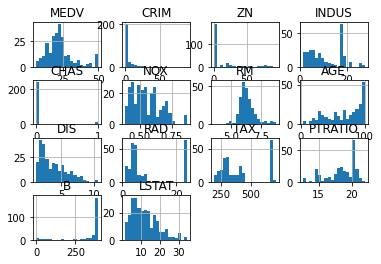

In [5]:
import scipy.cluster.hierarchy as spc

def plot_corr(df, cluster=False, absolute=False):
    '''
    Prints 
    
    :params df: pd.df
    :params cluster: sorts column if True. bool
    :returns: correlation matrix. pandas.io.formats.style.Styler object
    '''
    corr = df.corr()
    
    if absolute :
        corr = corr.abs()
    
    if cluster :
        pdist = spc.distance.pdist(corr)
        linkage = spc.linkage(pdist, method='complete')
        idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
        new_index = [x for _,x in sorted(zip(idx,list(df.columns)))]
        corr = corr.reindex(new_index)[new_index]
        
        output = corr \
            .style.background_gradient(cmap='coolwarm') \
            .set_precision(2) \
            .set_table_attributes('style="font-size: 10px"')
            #.set_properties(**{'font-size': '0pt'})
    return output

df_all_train = pd.concat([df_targets_train, df_feature_train],axis=1)
pprint(((df_all_train-df_all_train.mean()) / (df_all_train.max()-df_all_train.min())).boxplot())
pprint(df_all_train.hist(bins=20))
pprint(plot_corr(df_feature_train, cluster=True))#.render()


In [6]:
#df_targets_train.sort_values(ascending=False).head(n=20)
#df_feature_train['NOX'].sort_values(ascending=False).head(n=100).hist(bins=30)
#df_feature_train['PTRATIO'].sort_values(ascending=False).head(n=100).hist(bins=30)
pprint('''Contains Outlier : MEDV, NOX, RAD (가격, 일산화질소 농도)
최대값에 빈도가 몰려 있다. MEDV는 clipping된 것 같다. NOX의 경우 Belsley (1980)에 따르면 오류값일 가능성이 높다.
따라서 training 및 test set에서 제거하는 것이 예측력을 높일 수 있다.
RAD에도 유사한 패턴이 있지만, 이것을 제거하면 MEDV와의 correlation이 0.1 정도로 매우 작아지기 때문에 제거하지 않는다.''')
pprint('''Skewed : CRIM, PTRATIO, INDUS, ZN, B (범죄, 교육, 공해, 대저택, 흑인)
특정 지역에 실제로 집중되어 분포가 Skew 되어 있을 수 있다.''')
pprint('''Multimodal : TAX (재산세율)
숨겨진 변수 때문일 수 있다. Harrison (1978)에 따르면 town간 과세평가적용률이 무시되었다.
만약 그렇다면 linear fitting은 잘 작동하지 않을 가능성이 높고, 특성 교차를 이용하는 것이 효과적일 수 있다.''')
pprint('''Continuous : RM, LSTAT, AGE, DIS (방 개수, 하위계층 비율, 오래된 주택 비율, 통근거리)
주택 품질에 대한 데이터는 대체로 연속적이다. 그러나 RM을 제외하면 대체로 정규분포에서 벗어나 있다.''')

 => Contains Outlier : MEDV, NOX, RAD (가격, 일산화질소 농도)
최대값에 빈도가 몰려 있다. MEDV는 clipping된 것 같다. NOX의 경우 Belsley (1980)에 따르면 오류값일 가능성이 높다.
따라서 training 및 test set에서 제거하는 것이 예측력을 높일 수 있다.
RAD에도 유사한 패턴이 있지만, 이것을 제거하면 MEDV와의 correlation이 0.1 정도로 매우 작아지기 때문에 제거하지 않는다.

 => Skewed : CRIM, PTRATIO, INDUS, ZN, B (범죄, 교육, 공해, 대저택, 흑인)
특정 지역에 실제로 집중되어 분포가 Skew 되어 있을 수 있다.

 => Multimodal : TAX (재산세율)
숨겨진 변수 때문일 수 있다. Harrison (1978)에 따르면 town간 과세평가적용률이 무시되었다.
만약 그렇다면 linear fitting은 잘 작동하지 않을 가능성이 높고, 특성 교차를 이용하는 것이 효과적일 수 있다.

 => Continuous : RM, LSTAT, AGE, DIS (방 개수, 하위계층 비율, 오래된 주택 비율, 통근거리)
주택 품질에 대한 데이터는 대체로 연속적이다. 그러나 RM을 제외하면 대체로 정규분포에서 벗어나 있다.



<AxesSubplot:>

array([[<AxesSubplot:title={'center':'MEDV'}>,
        <AxesSubplot:title={'center':'CRIM'}>,
        <AxesSubplot:title={'center':'ZN'}>,
        <AxesSubplot:title={'center':'INDUS'}>,
        <AxesSubplot:title={'center':'CHAS'}>],
       [<AxesSubplot:title={'center':'NOX'}>,
        <AxesSubplot:title={'center':'RM'}>,
        <AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'DIS'}>,
        <AxesSubplot:title={'center':'RAD'}>],
       [<AxesSubplot:title={'center':'TAX'}>,
        <AxesSubplot:title={'center':'PTRATIO'}>,
        <AxesSubplot:title={'center':'B'}>,
        <AxesSubplot:title={'center':'LSTAT'}>, <AxesSubplot:>]],
      dtype=object)

,AGE,CRIM,INDUS,LSTAT,NOX,PTRATIO,RAD,TAX,B,DIS,MEDV,RM,ZN,CHAS
AGE,1.00,0.34,0.63,0.57,0.76,0.28,0.47,0.51,-0.25,-0.72,-0.45,-0.15,-0.54,0.05
CRIM,0.34,1.00,0.40,0.43,0.49,0.28,0.62,0.57,-0.33,-0.38,-0.42,-0.12,-0.20,-0.04
INDUS,0.63,0.40,1.00,0.60,0.77,0.42,0.59,0.69,-0.33,-0.69,-0.55,-0.33,-0.51,0.05
LSTAT,0.57,0.43,0.60,1.00,0.59,0.46,0.55,0.58,-0.42,-0.47,-0.75,-0.56,-0.42,-0.15
NOX,0.76,0.49,0.77,0.59,1.00,0.37,0.75,0.76,-0.39,-0.80,-0.52,-0.20,-0.55,0.00
PTRATIO,0.28,0.28,0.42,0.46,0.37,1.00,0.44,0.43,-0.21,-0.26,-0.55,-0.42,-0.40,-0.15
RAD,0.47,0.62,0.59,0.55,0.75,0.44,1.00,0.91,-0.47,-0.50,-0.49,-0.21,-0.31,-0.01
TAX,0.51,0.57,0.69,0.58,0.76,0.43,0.91,1.00,-0.45,-0.52,-0.58,-0.28,-0.32,-0.04
B,-0.25,-0.33,-0.33,-0.42,-0.39,-0.21,-0.47,-0.45,1.00,0.27,0.38,0.10,0.17,0.07
DIS,-0.72,-0.38,-0.69,-0.47,-0.80,-0.26,-0.50,-0.52,0.27,1.00,0.29,0.08,0.60,-0.08


,AGE,DIS,INDUS,NOX,ZN,CRIM,LSTAT,MEDV,RAD,TAX,B,PTRATIO,RM,CHAS
AGE,1.00,0.72,0.63,0.76,0.54,0.34,0.57,0.45,0.47,0.51,0.25,0.28,0.15,0.05
DIS,0.72,1.00,0.69,0.80,0.60,0.38,0.47,0.29,0.50,0.52,0.27,0.26,0.08,0.08
INDUS,0.63,0.69,1.00,0.77,0.51,0.40,0.60,0.55,0.59,0.69,0.33,0.42,0.33,0.05
NOX,0.76,0.80,0.77,1.00,0.55,0.49,0.59,0.52,0.75,0.76,0.39,0.37,0.20,0.00
ZN,0.54,0.60,0.51,0.55,1.00,0.20,0.42,0.37,0.31,0.32,0.17,0.40,0.27,0.02
CRIM,0.34,0.38,0.40,0.49,0.20,1.00,0.43,0.42,0.62,0.57,0.33,0.28,0.12,0.04
LSTAT,0.57,0.47,0.60,0.59,0.42,0.43,1.00,0.75,0.55,0.58,0.42,0.46,0.56,0.15
MEDV,0.45,0.29,0.55,0.52,0.37,0.42,0.75,1.00,0.49,0.58,0.38,0.55,0.61,0.13
RAD,0.47,0.50,0.59,0.75,0.31,0.62,0.55,0.49,1.00,0.91,0.47,0.44,0.21,0.01
TAX,0.51,0.52,0.69,0.76,0.32,0.57,0.58,0.58,0.91,1.00,0.45,0.43,0.28,0.04


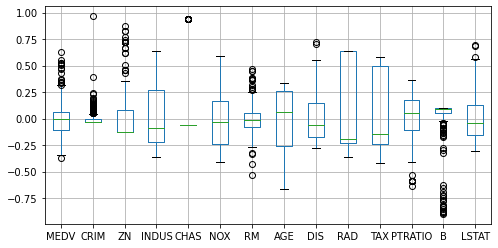

<Figure size 432x288 with 0 Axes>

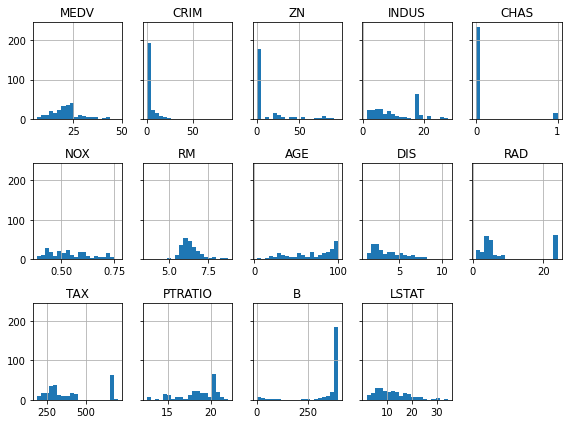

In [7]:
def preprocess_features(boston_housing_dataframe):
    '''
    Prepare features

    :param df: Raw pd.df containing Boston housing data
    :return: df_feature_train, df_feature_test, df_feature_validate, df_targets_train, df_targets_test, df_targets_validate
    '''
    feature = boston_housing_dataframe.copy()
    targets = pd.DataFrame(feature.pop('MEDV'))

    df_feature_train, df_feature_test, df_feature_validate, df_targets_train, df_targets_test, df_targets_validate \
    = *cut_data(feature,[0.5,0.2]), *cut_data(targets,[0.5,0.2])
    
    df_targets_train = df_targets_train[df_targets_train.MEDV!=df_targets_train.MEDV.max()]
    df_feature_train = df_feature_train[df_feature_train.NOX !=df_feature_train.NOX.max() ]
    #df_feature_train['NOX'] = np.power(df_feature_train['NOX'],2) # Belsley (1980)
    #df_feature_train['RM' ] = np.power(df_feature_train['RM' ],2) # Harrison (1978)
    
    df_targets_test  = df_targets_test [df_targets_test .MEDV!=df_targets_test .MEDV.max()]
    df_feature_test  = df_feature_test [df_feature_test .NOX !=df_feature_test .NOX.max() ]
    #df_feature_test ['NOX'] = np.power(df_feature_test ['NOX'],2) # Belsley (1980)
    #df_feature_train['RM' ] = np.power(df_feature_train['RM' ],2) # Harrison (1978)

    return df_feature_train, df_feature_test, df_feature_validate, df_targets_train, df_targets_test, df_targets_validate


df_feature_train, df_feature_test, df_feature_validate, df_targets_train, df_targets_test, df_targets_validate \
= preprocess_features(df_boston_housing)

df_all_train = pd.concat([df_targets_train, df_feature_train],axis=1)
pprint(((df_all_train-df_all_train.mean()) / (df_all_train.max()-df_all_train.min())).boxplot(figsize=(8,4)))
pprint(df_all_train.hist(bins=20, figsize=(8,6), layout=(3,5), sharey=True))
plt.tight_layout()
pprint(plot_corr(df_all_train, cluster=True))#.render()
pprint(plot_corr(df_all_train, cluster=True, absolute=True))#.render()

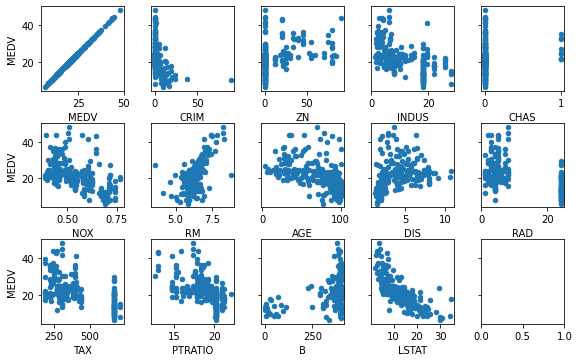

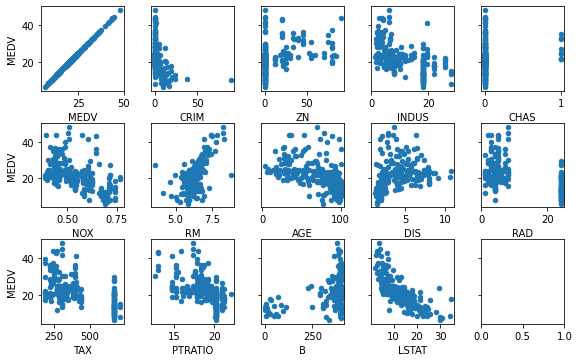

<Figure size 432x288 with 0 Axes>

In [8]:
fig, ax = plt.subplots(3, 5, figsize=(8,5), sharey=True)
fig.tight_layout()
ax_flat = ax.flatten()
for i in range(df_all_train.shape[1]):
    df_all_train.plot.scatter(df_all_train.columns[i], 'MEDV', ax=ax_flat[i])
    
pprint(fig)

Adding LSTAT	Score: 0.62 vs 0.13
Adding PTRATIO	Score: 0.89 vs 0.85
Adding B	Score: 1.04 vs 0.85
Adding RM	Score: 1.16 vs 0.85
Adding AGE	Score: 1.12 vs 0.85
Adding CRIM	Score: 1.12 vs 0.85
Adding ZN	Score: 0.99 vs 0.85
Adding TAX	Score: 0.93 vs 0.85


<AxesSubplot:title={'center':'Within-group correlation (selected features)'}>

<AxesSubplot:title={'center':'Between-group correlation (selected features, rejected features)'}>

 => 
selected_features: ['LSTAT', 'PTRATIO', 'B', 'RM', 'AGE', 'CRIM', 'ZN', 'TAX']
rejected_features : ['INDUS', 'CHAS', 'NOX', 'DIS', 'RAD']



['LSTAT', 'PTRATIO', 'B', 'RM', 'AGE', 'CRIM', 'ZN', 'TAX']

<Figure size 432x288 with 0 Axes>

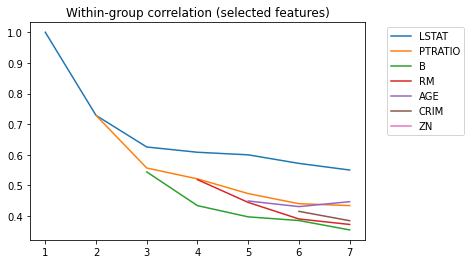

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

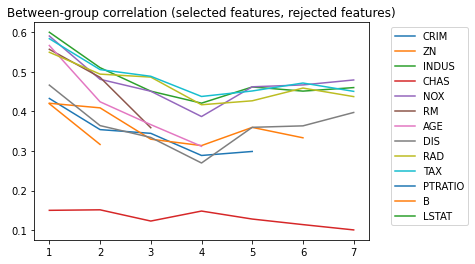

<Figure size 432x288 with 0 Axes>

In [9]:
def greedy_feature_selection(df, target_name, dummy_name):
    #corr_all = df.copy().rank().corr().abs()
    corr_all = df.copy().corr().abs()
    
    target = df[target_name]
    selected_feature = []#['NOX','RM','LSTAT']
    rejected_feature = [x for x in df.columns if x is not target_name]
    
    def thres_score(too_bad, good_enough):
        return (
            lambda x : np.interp(x, [-1000, too_bad, good_enough, 10000], [-10000,0,good_enough,1000]) if np.isfinite(x) else 0
        )   
    
    within_group_corr = []
    between_group_corr = []
    while (len(rejected_feature)>0) :
        prediction_power = corr_all.loc()['MEDV'][rejected_feature].map( thres_score(0.0,0.6) )
        correlation = corr_all.loc()[rejected_feature][selected_feature]
        uniqueness = correlation.apply(lambda x : 1.0-x.mean(),axis=1).map( thres_score(1.0-0.6,1.0-0.3) )
        self_correlation = corr_all.loc()[selected_feature][selected_feature].mean(axis=1)
        score = prediction_power+uniqueness
        winner = score.idxmax()
        if (winner == dummy_name) :
            break
        print(f'Adding {winner}\tScore: {score[winner]:.2f} vs {score[dummy_name]:.2f}')
        within_group_corr+=[self_correlation.copy()]
        between_group_corr+=[correlation.mean(axis=1).copy()]
        rejected_feature.remove(winner)
        selected_feature.append(winner)
    
    plt.figure()
    p = pd.concat(within_group_corr,axis=1).T.plot(title='Within-group correlation (selected features)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    pprint(p)
    plt.figure()
    p = pd.concat(between_group_corr,axis=1).T.plot(title='Between-group correlation (selected features, rejected features)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    pprint(p)
    pprint(f'\nselected_features: {selected_feature}\nrejected_features : {rejected_feature}')
    return selected_feature

greedy_feature_selection(df_all_train,'MEDV','CHAS')
#df_all_train.plot()

In [10]:

From correlation matrix, we see TAX and RAD are highly correlated features. T
he columns LSTAT, INDUS, RM, TAX, NOX, PTRAIO has a correlation score above 
0.5 with MEDV which is a good indication of using as predictors. 
Let's plot these columns against MEDV.

In [9]:
from sklearn import preprocessing
# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data.loc[:,column_sels]
y = data['MEDV']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

So with these analsis, we may try predict MEDV with 'LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE' features. Let's try to remove the skewness of the data trough log transformation.

SyntaxError: invalid syntax (<ipython-input-10-59337a71054a>, line 1)

In [ ]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a linear regression model.
    
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
    
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
            consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        training_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for training.
        validation_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for validation.
        validation_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for validation.
            
    Returns:
        A `LinearRegressor` object trained on the training data.
    """

    periods = 10
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
            feature_columns=construct_feature_columns(training_examples),
            optimizer=my_optimizer
    )
        
    # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
        training_targets["median_house_value"], 
        batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
        training_targets["median_house_value"], 
        num_epochs=1, 
        shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
        validation_targets["median_house_value"], 
        num_epochs=1, 
        shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
                input_fn=training_input_fn,
                steps=steps_per_period,
        )
        # Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
                metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
                metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print(" period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    
    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np

l_regression = linear_model.LinearRegression()
kf = KFold(n_splits=10)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scores = cross_val_score(l_regression, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

scores_map = {}
scores_map['LinearRegression'] = scores
l_ridge = linear_model.Ridge()
scores = cross_val_score(l_ridge, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['Ridge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

# Lets try polinomial regression with L2 with degree for the best fit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
#for degree in range(2, 6):
#    model = make_pipeline(PolynomialFeatures(degree=degree), linear_model.Ridge())
#    scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
#    print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
model = make_pipeline(PolynomialFeatures(degree=3), linear_model.Ridge())
scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['PolyRidge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(alpha=0.9,learning_rate=0.05, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100, random_state=30)
#param_grid={'n_estimators':[100, 200], 'learning_rate': [0.1,0.05,0.02], 'max_depth':[2, 4,6], 'min_samples_leaf':[3,5,9]}
#grid_sv = GridSearchCV(gbr, cv=kf, param_grid=param_grid, scoring='neg_mean_squared_error')
#grid_sv.fit(x_scaled, y)
#print("Best classifier :", grid_sv.best_estimator_)
scores = cross_val_score(gbr, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['GradientBoostingRegressor'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [ ]:
PDFkit, Jinja2
#https://towardsdatascience.com/creating-pdf-reports-with-python-pdfkit-and-jinja2-templates-64a89158fa2d